In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import xgboost as xgb 
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import datetime

Read Data

In [2]:
df = pd.read_csv("../data/raw/PJME_hourly.csv")
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [3]:
df = df.sort_values(by="Datetime", ascending=True)
df = df.set_index("Datetime")
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [4]:
df.index.dtype

dtype('O')

In [5]:
pd.to_datetime(df.index)

DatetimeIndex(['2002-01-01 01:00:00', '2002-01-01 02:00:00',
               '2002-01-01 03:00:00', '2002-01-01 04:00:00',
               '2002-01-01 05:00:00', '2002-01-01 06:00:00',
               '2002-01-01 07:00:00', '2002-01-01 08:00:00',
               '2002-01-01 09:00:00', '2002-01-01 10:00:00',
               ...
               '2018-08-02 15:00:00', '2018-08-02 16:00:00',
               '2018-08-02 17:00:00', '2018-08-02 18:00:00',
               '2018-08-02 19:00:00', '2018-08-02 20:00:00',
               '2018-08-02 21:00:00', '2018-08-02 22:00:00',
               '2018-08-02 23:00:00', '2018-08-03 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=145366, freq=None)

In [6]:
df.index = pd.to_datetime(df.index)

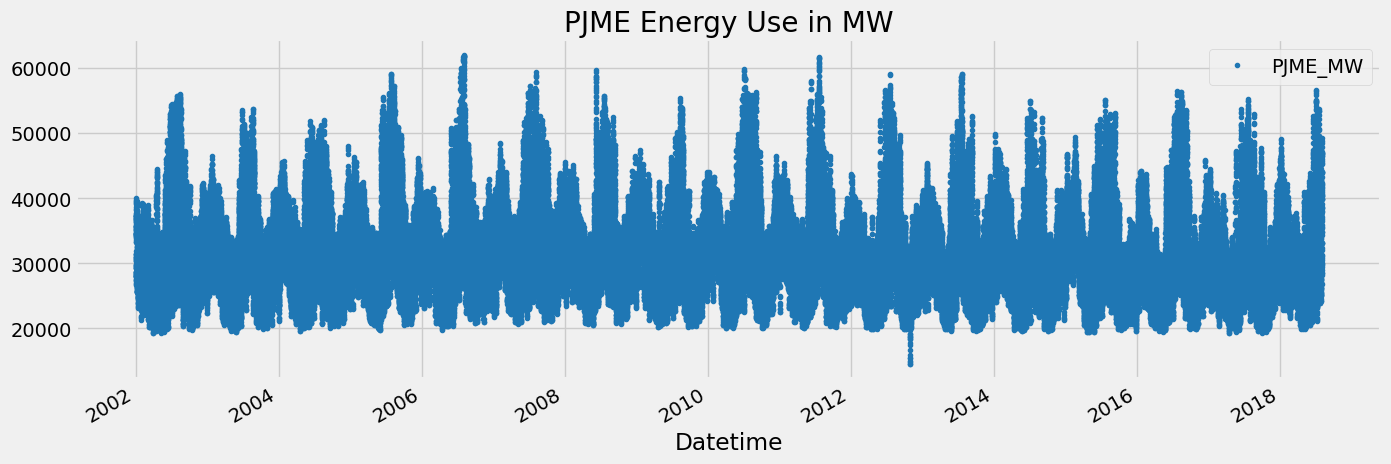

In [10]:
df.plot(style=".", figsize=(15,5), color = color_pal[0], title="PJME Energy Use in MW")
plt.show()

Outlier Detection

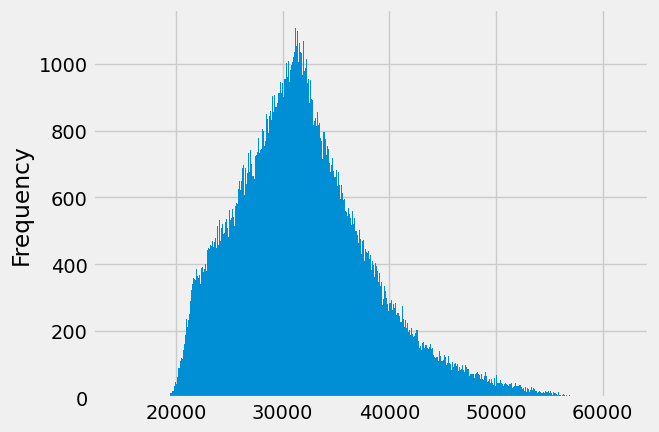

In [11]:
df["PJME_MW"].plot(kind="hist", bins=500)
plt.show()

<Axes: title={'center': 'Outliers Investigation'}, xlabel='Datetime'>

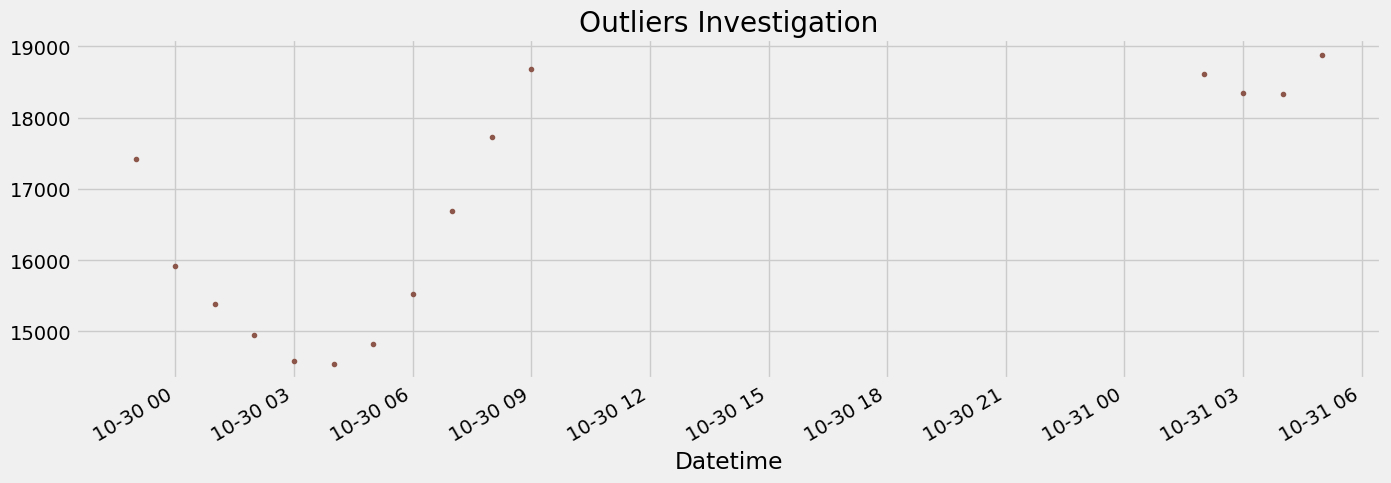

In [12]:
(df.query("PJME_MW < 19_000")["PJME_MW"]).plot(style=".", figsize=(15,5), color= color_pal[5], title="Outliers Investigation")

Remove outliers

In [13]:
df = df.query("PJME_MW > 19_000").copy()

ML: Split Data

In [14]:
train = df.loc[df.index < "01-01-2015"]
test = df.loc[df.index >= "01-01-2015"]

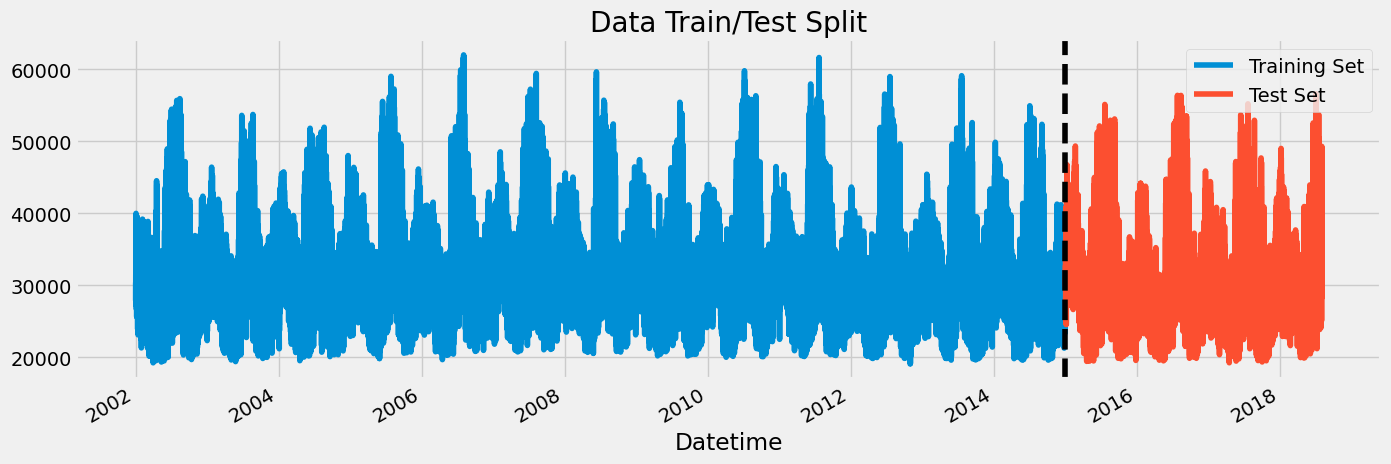

In [15]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label="Training Set", title="Data Train/Test Split")
test.plot(ax=ax, label="Test Set")

ax.axvline("01-01-2015", color="black", ls= "--")
ax.legend(["Training Set", "Test Set"])
plt.show()

Time Series Cross Validation

In [17]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size= 24*365*1, gap=24)  #24 hrs in a day, 365 days in a year for 1 year, leave a gap of 24 hrs between train/test set
df = df.sort_index()

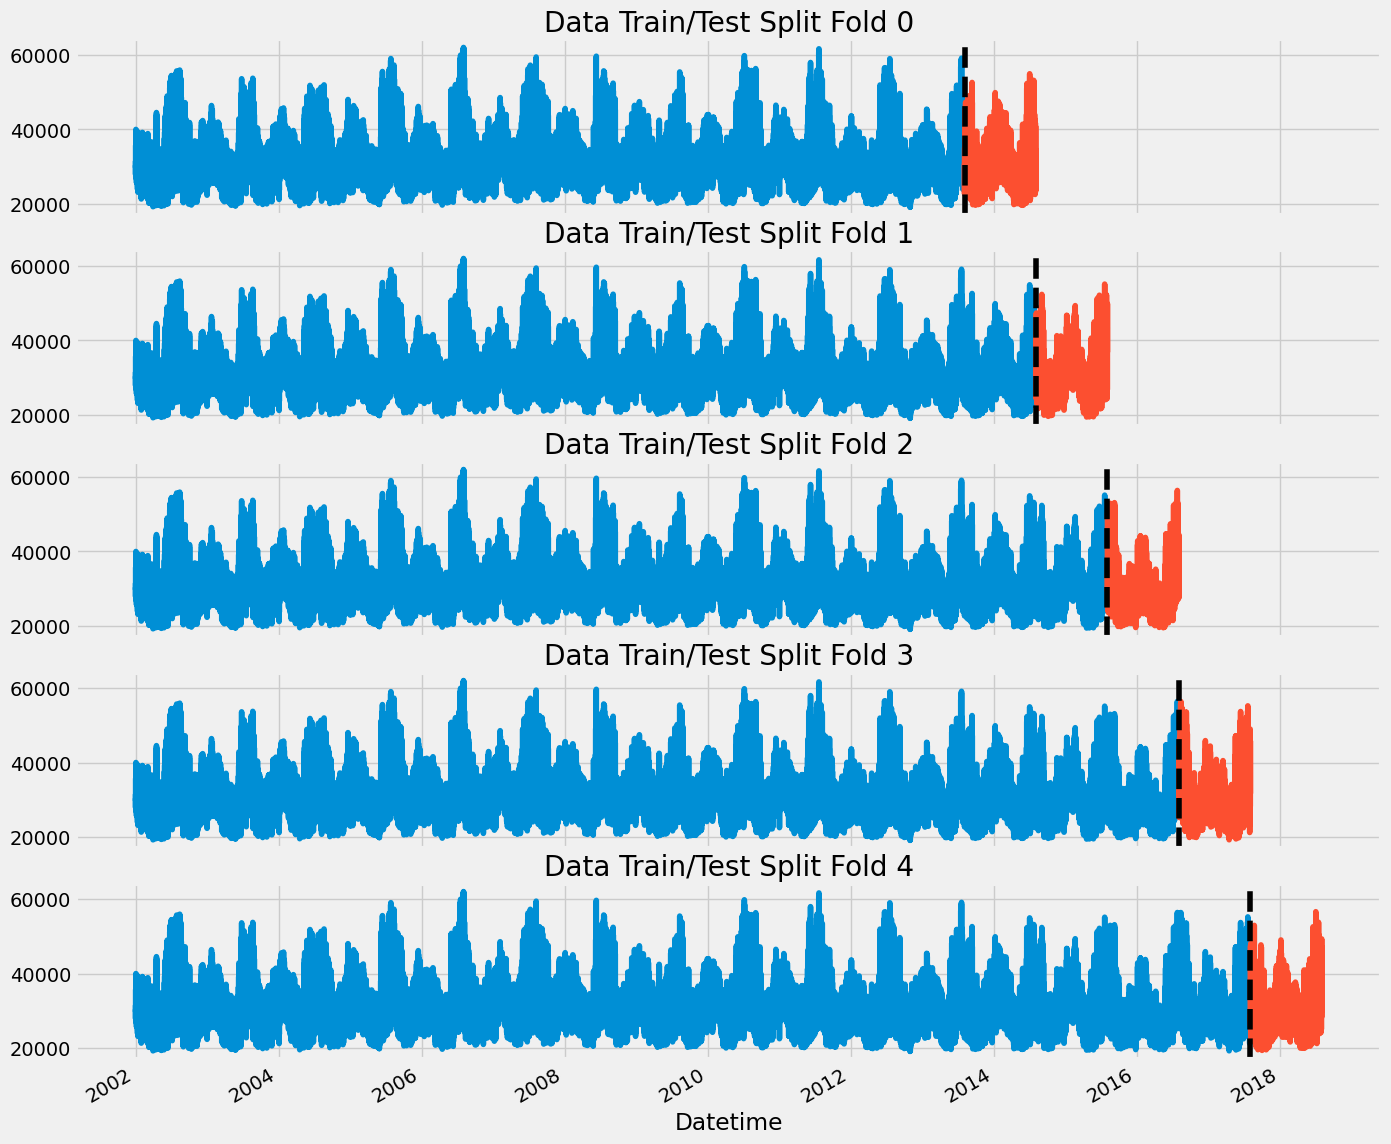

In [18]:
fig, ax = plt.subplots(5,1,figsize=(15,15), sharex=True)


fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train["PJME_MW"].plot(ax=ax[fold], label="Training Set", title= f"Data Train/Test Split Fold {fold}")
    test["PJME_MW"].plot(ax=ax[fold], label="Test Set")
    ax[fold].axvline(test.index.min(), color="black", ls = "--")
    
    fold += 1
plt.show()

## Feature Engineering

In [19]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    df["dayofmonth"] = df.index.day
    df["weekof year"] = df.index.isocalendar().week
    
    return df

In [20]:
df = create_features(df)
df.head(10)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekof year
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1
2002-01-01 06:00:00,28654.0,6,1,1,1,2002,1,1,1
2002-01-01 07:00:00,29308.0,7,1,1,1,2002,1,1,1
2002-01-01 08:00:00,29595.0,8,1,1,1,2002,1,1,1
2002-01-01 09:00:00,29943.0,9,1,1,1,2002,1,1,1


Lag Features

In [21]:
def create_lags(df):
    """
    craeting lags 
    """
    target_map = df["PJME_MW"].to_dict()
    
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    
    return df

In [22]:
df = create_lags(df)

In [23]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekof year', 'lag1', 'lag2', 'lag3'],
      dtype='object')

In [24]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)

#make sure data has been sorted

fold = 0

preds= []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    train = create_features(train)
    train = create_lags(train)
    
    test = df.iloc[val_idx]
    test = create_features(test)
    test = create_lags(test)
    
    Features =  ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekof year', 'lag1', 'lag2', 'lag3']
    Taregt = 'PJME_MW'
    
    X_train = train[Features]
    y_train = train[Taregt]
    
    X_test = test[Features]
    y_test = test[Taregt]
    
  
    reg = xgb.XGBRegressor(base_score=0.5, booster= 'gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective = 'reg:linear',
                           max_depth=3,
                           learning_rate=0.01, gpu=True)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
                      verbose=100)
    
    y_pred = reg.predict(X_test)
    
    preds.append(y_pred)
    
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31972.18933


/workspaces/time-series-practice-/timeseries-venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:14:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/workspaces/time-series-practice-/timeseries-venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:14:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "gpu" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.62163	validation_1-rmse:12923.42205
[200]	validation_0-rmse:5747.40346	validation_1-rmse:6894.18238
[300]	validation_0-rmse:3873.86657	validation_1-rmse:5089.58436
[400]	validation_0-rmse:3439.00295	validation_1-rmse:4569.21665
[500]	validation_0-rmse:3317.13290	validation_1-rmse:4354.38835
[600]	validation_0-rmse:3260.32360	validation_1-rmse:4251.40574
[700]	validation_0-rmse:3219.67297	validation_1-rmse:4181.80277
[800]	validation_0-rmse:3185.70397	validation_1-rmse:4141.61426
[900]	validation_0-rmse:3154.90933	validation_1-rmse:4124.30695
[999]	validation_0-rmse:3123.83349	validation_1-rmse:4111.02695
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32155.15924


/workspaces/time-series-practice-/timeseries-venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:14:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/workspaces/time-series-practice-/timeseries-venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:14:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "gpu" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.65311	validation_1-rmse:13162.86050
[200]	validation_0-rmse:5752.76516	validation_1-rmse:7098.62925
[300]	validation_0-rmse:3900.67413	validation_1-rmse:5292.14547
[400]	validation_0-rmse:3474.73687	validation_1-rmse:4767.42280
[500]	validation_0-rmse:3349.40893	validation_1-rmse:4672.19881
[600]	validation_0-rmse:3293.80186	validation_1-rmse:4638.40964
[700]	validation_0-rmse:3250.27600	validation_1-rmse:4585.30936
[800]	validation_0-rmse:3212.58946	validation_1-rmse:4557.83652
[833]	validation_0-rmse:3202.32401	validation_1-rmse:4557.14880
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31092.78640


/workspaces/time-series-practice-/timeseries-venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:14:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/workspaces/time-series-practice-/timeseries-venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:14:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "gpu" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.28504	validation_1-rmse:12284.99098
[200]	validation_0-rmse:5750.28699	validation_1-rmse:6657.01535
[300]	validation_0-rmse:3920.38250	validation_1-rmse:5195.26873
[400]	validation_0-rmse:3496.62138	validation_1-rmse:4658.36923
[500]	validation_0-rmse:3377.88219	validation_1-rmse:4518.98113
[600]	validation_0-rmse:3318.81047	validation_1-rmse:4372.02850
[700]	validation_0-rmse:3274.94642	validation_1-rmse:4246.46560
[800]	validation_0-rmse:3238.28788	validation_1-rmse:4174.04294
[900]	validation_0-rmse:3214.54222	validation_1-rmse:4149.62545
[999]	validation_0-rmse:3188.61487	validation_1-rmse:4113.52387
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31487.92247


/workspaces/time-series-practice-/timeseries-venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:14:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/workspaces/time-series-practice-/timeseries-venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:14:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "gpu" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.30097	validation_1-rmse:12705.54575
[200]	validation_0-rmse:5738.03687	validation_1-rmse:7085.01287
[300]	validation_0-rmse:3914.12677	validation_1-rmse:5557.24802
[400]	validation_0-rmse:3497.66134	validation_1-rmse:4966.05782
[500]	validation_0-rmse:3381.34109	validation_1-rmse:4755.02835
[600]	validation_0-rmse:3322.04259	validation_1-rmse:4587.85847
[700]	validation_0-rmse:3279.20567	validation_1-rmse:4510.40409
[800]	validation_0-rmse:3247.16453	validation_1-rmse:4466.20050
[900]	validation_0-rmse:3221.85798	validation_1-rmse:4438.14514
[999]	validation_0-rmse:3194.47591	validation_1-rmse:4403.46549
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31476.55667


/workspaces/time-series-practice-/timeseries-venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:14:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/workspaces/time-series-practice-/timeseries-venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:14:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "gpu" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.92251	validation_1-rmse:12534.55644
[200]	validation_0-rmse:5750.67944	validation_1-rmse:6683.00612
[300]	validation_0-rmse:3951.95750	validation_1-rmse:5140.96149
[400]	validation_0-rmse:3538.74569	validation_1-rmse:4763.25563
[500]	validation_0-rmse:3425.29719	validation_1-rmse:4659.16438
[600]	validation_0-rmse:3369.30691	validation_1-rmse:4610.65867
[700]	validation_0-rmse:3330.80683	validation_1-rmse:4579.16331
[800]	validation_0-rmse:3297.08316	validation_1-rmse:4567.42009
[846]	validation_0-rmse:3281.68416	validation_1-rmse:4567.41489


In [25]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 4347.9311
Fold scores:[np.float64(4111.026946420989), np.float64(4548.257246272663), np.float64(4111.794756194369), np.float64(4403.465493121795), np.float64(4565.111065137379)]


In [26]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.88991


/workspaces/time-series-practice-/timeseries-venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:24:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.77634
[200]	validation_0-rmse:5753.18185
[300]	validation_0-rmse:3970.09750
[400]	validation_0-rmse:3569.04143
[499]	validation_0-rmse:3456.41787


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [27]:
#last datetime
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [28]:
# Create future dataframe
future_index = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future_index)

In [29]:
future_df

""
2018-08-03 00:00:00
2018-08-03 01:00:00
2018-08-03 02:00:00
2018-08-03 03:00:00
2018-08-03 04:00:00
...
2019-07-31 20:00:00
2019-07-31 21:00:00
2019-07-31 22:00:00
2019-07-31 23:00:00


In [32]:
future_df['isFuture'] = True
df['isFuture'] = False

In [34]:
df_and_future = pd.concat([df, future_df])
df_and_future

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekof year,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1.0,1.0,1.0,1.0,2002.0,1.0,1.0,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2.0,1.0,1.0,1.0,2002.0,1.0,1.0,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3.0,1.0,1.0,1.0,2002.0,1.0,1.0,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4.0,1.0,1.0,1.0,2002.0,1.0,1.0,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5.0,1.0,1.0,1.0,2002.0,1.0,1.0,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
2019-07-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
2019-07-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True
2019-07-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,True


In [36]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekof year,lag1,lag2,lag3,isFuture
Datetime,,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0,False
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0,False
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0,False


In [35]:
df_and_future = create_features(df_and_future)
df_and_future

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekof year,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,NaN,NaN,NaN,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,NaN,NaN,NaN,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,NaN,NaN,NaN,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,NaN,NaN,NaN,True


In [37]:
df_and_future = create_lags(df_and_future)
df_and_future

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekof year,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [42]:
df_and_future.query('isFuture == 1')

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekof year,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True


In [43]:
future_w_features = df_and_future.query('isFuture').copy()

In [51]:
future_w_features['PJME_MW'] = reg.predict(future_w_features[FEATURES])

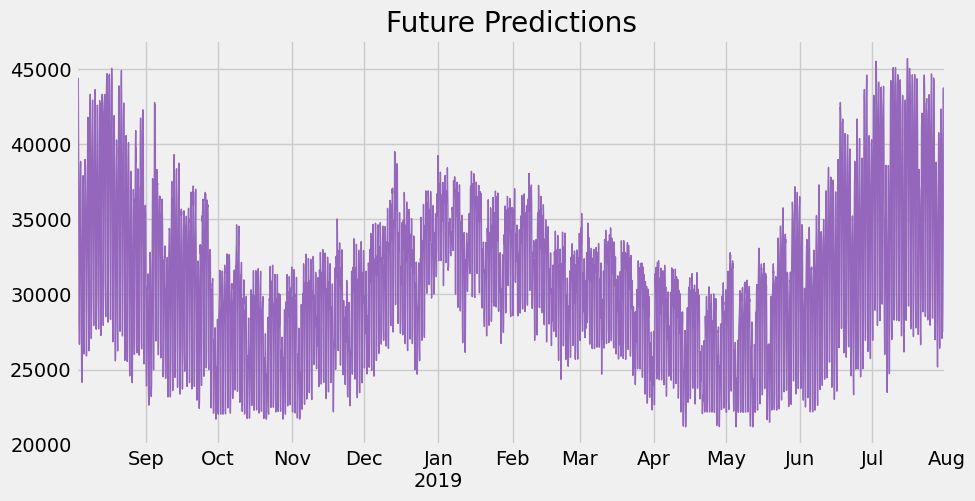

In [52]:
future_w_features['PJME_MW'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

Saving Model

In [47]:
reg.save_model("../artifacts/model.jason")

/workspaces/time-series-practice-/timeseries-venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:39:10] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [50]:
!ls -lh

total 820K
-rw-rw-rw- 1 codespace codespace 820K Jun 27 16:39 expirement.ipynb


Visualize all data

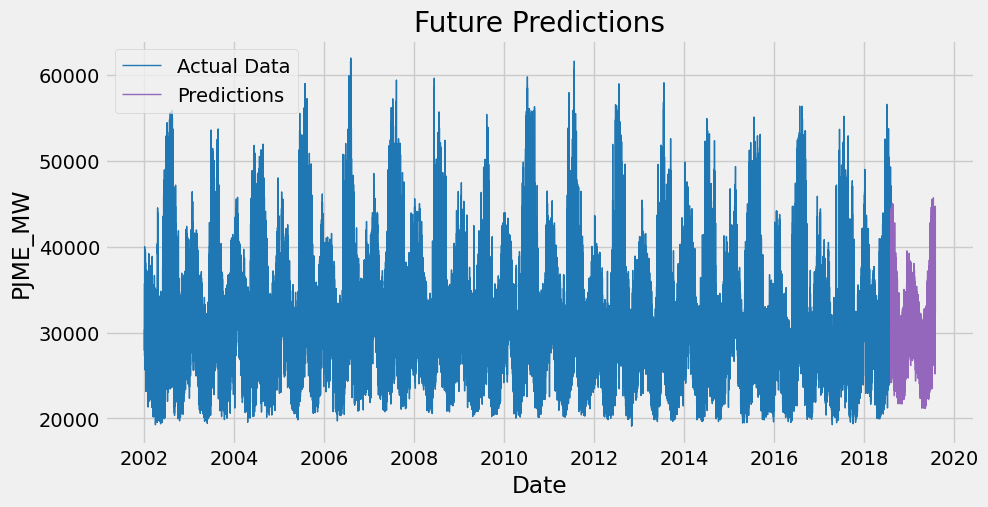

In [77]:
plt.figure(figsize=(10, 5))

# Plot the actual data
plt.plot(df.index, df['PJME_MW'], label='Actual Data', color=color_pal[0], lw=1)

# Plot the predicted data
plt.plot(future_w_features.index, future_w_features['PJME_MW'], label='Predictions', color=color_pal[4], lw=1)

# Adding titles and labels
plt.title('Future Predictions')
plt.xlabel('Date')
plt.ylabel('PJME_MW')

# Adding a legend
plt.legend()

# Show the plot
plt.show()